In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Machine Learning/Intern/Lec_2/Voice_Vertification/

/content/drive/MyDrive/Machine Learning/Intern/Lec_2/Voice_Vertification


In [ ]:
# !unzip Zalo_Voice_Verification.zip

# Utils

In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
import random 
import glob

In [ ]:
DATA_ROOT = 'Zalo_Voice_Verification/Train-Test-Data/dataset'
subject_foders = os.listdir(DATA_ROOT)
print(len(subject_foders))
test_subject_folder =  os.path.join(DATA_ROOT, random.choice(subject_foders)) 

400


In [ ]:
test_audio_file1 = os.path.join(test_subject_folder,random.choice(os.listdir(test_subject_folder)))
ipd.Audio(test_audio_file1)

In [ ]:
test_audio_file = os.path.join(test_subject_folder,random.choice(os.listdir(test_subject_folder)))
ipd.Audio(test_audio_file)

In [ ]:
signal, sr = librosa.load(test_audio_file1)

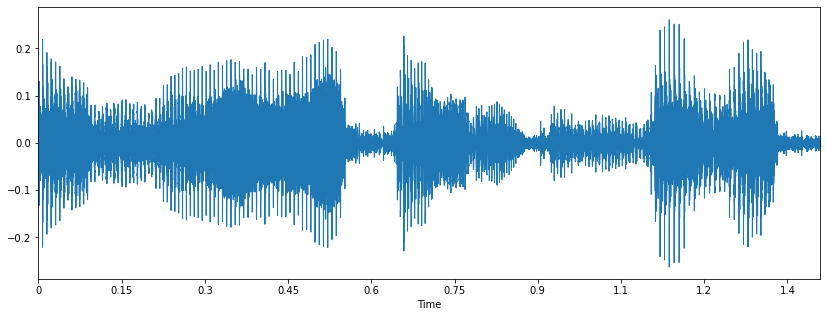

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(signal, sr)

In [ ]:
mfccs = librosa.feature.mfcc(signal, n_mfcc=13, sr=sr)
mfccs.shape

(13, 61)

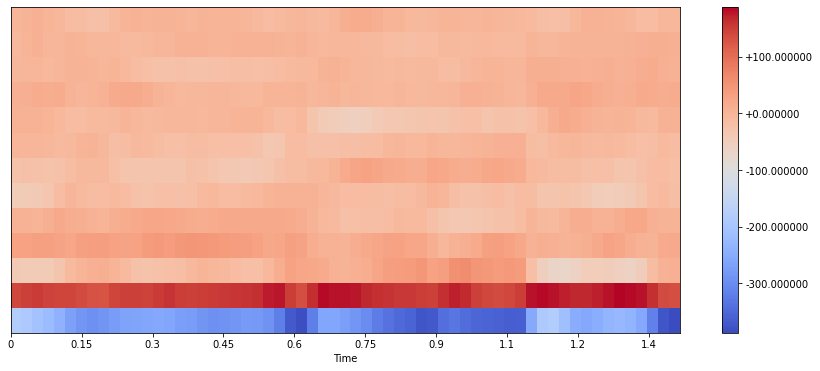

In [ ]:
plt.figure(figsize=(15,6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format="%+2f")
plt.show()

# MLP

In [ ]:
from matplotlib import cm
import csv
from tqdm.notebook import tqdm

def extract(total_wave_files, csvFileName):
    header = 'subject_label chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header = header.split()
    file = open(csvFileName, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(header)
    for filename in total_wave_files:
        y, sr = librosa.load(filename, mono=True, duration=5)
        # remove leading and trailing silence
        y, index = librosa.effects.trim(y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        subject_label = subject_foders.index(filename.split('/')[-2])
        to_append = f'{subject_label} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        writer.writerow(to_append.split())
    file.close()

total_wave_files = glob.glob(os.path.join(DATA_ROOT,'*/*.wav'))
csvFileName = './data.csv'
# extract(total_wave_files, csvFileName)

In [ ]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = pd.read_csv(csvFileName)
data = data.drop(['chroma_stft'],axis=1)
X = np.array(data.iloc[:, 1:], dtype = float)
y = np.array(data.iloc[:, 0],dtype = int)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Y from training data:", y_train.shape)
print("Y from validation data:", y_val.shape)

Y from training data: (8448,)
Y from validation data: (2112,)


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
from keras import models
from keras import layers
import keras
from keras.callbacks import EarlyStopping


model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(400, activation='softmax'))

try:
  model = keras.models.load_model("model.h5")
except:
  pass

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    batch_size=256,
                    callbacks=[es])
model.save('model.h5')

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
def embedd(wave_files):  
  csvFileName = './test_data.csv'
  extract(wave_files, csvFileName)
  data = pd.read_csv(csvFileName)
  data = data.drop(['chroma_stft'],axis=1)
  X = np.array(data.iloc[:, 1:], dtype = float)
  y = np.array(data.iloc[:, 0],dtype = int)
  X = scaler.fit_transform(X)
  return X,y

In [ ]:
def report(X_data, y_data):
    Y_pred = model.predict(X_data)
    Y_pred = keras.backend.argmax(Y_pred,axis = -1)
    print("Predict: ", Y_pred.numpy())
    print("Truth: ",y_data)

In [ ]:
X,y = embedd([test_audio_file,test_audio_file1])
report(X, y)

# SVM

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

In [ ]:
print(X_val.shape)

In [ ]:
print(clf.score(X_train,y_train))

0.8868371212121212


In [ ]:
public_test_file = 'path_to/Zalo_Voice_Verification/Train-Test-Data/public-test.csv'
test_files = pd.read_csv(public_test_file)
path = 'path_to/Zalo_Voice_Verification/Train-Test-Data/public-test'
test_files['audio_1'] = test_files['audio_1'].apply(lambda x: os.path.join(path, x))
test_files['audio_2'] = test_files['audio_2'].apply(lambda x: os.path.join(path, x))

In [ ]:
def extract_test(total_wave_files, csvFileName = './test_data.csv'):
    header = 'rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header = header.split()
    file = open(csvFileName, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(header)
    for filename in total_wave_files:
        y, sr = librosa.load(filename, mono=True, duration=5)
        # remove leading and trailing silence
        y, index = librosa.effects.trim(y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        writer.writerow(to_append.split())
    file.close()

def embedd(wave_files,csvFileName = './test_data.csv'):  
  extract_test(wave_files, csvFileName)
  data = pd.read_csv(csvFileName)
  X = np.array(data, dtype = float)
  X = scaler.fit_transform(X)
  return X

In [ ]:
file_pairs = test_files.to_numpy()
results = []
for pair in file_pairs:
  X = embedd(pair)
  y = clf.predict(X)
  print(y)
  result = 1 if y[0]==y[1] else 0
  print(result)
  results.append(result)
print("ACC = ", sum(results)/len(results))